In [1]:
import d2l
import torch
import matplotlib
from torch import nn
import torch.nn.functional as F
import torchvision

In [2]:
class BCE_IoU_Loss(nn.Module):
    """
    损失函数 L_total = L_BCE + L_IoU
    """
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth  # 平滑项

    def forward(self, preds, targets):
        # BCE损失
        bce_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')

        # IoU损失
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = (preds + targets).sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        iou_loss = 1 - iou

        # 组合损失
        total_loss = bce_loss.mean() + iou_loss.mean()
        return total_loss

In [3]:
# 获得编码器的预训练版本
import local_clip
import os
import torch
from pycocotools.coco import COCO
from PIL import Image

device = "mps" if torch.mps.is_available() else "cpu"
encoder, preprocess = local_clip.load("ViT-B/16", device=device)

image = preprocess(Image.open("../cocoseg/train2017/000000000009.jpg")).unsqueeze(0).to(device)

# 我们修改了 local_clip，使得 encode_image 可以返回最后一层 transformer 的 feature_map
with torch.no_grad():
    image, feature_map = encoder.encode_image(image)

# 特征向量
print(image.shape)
# Transformer 特征图
# Patches = 197 = (224/16)^2 + 1
print(feature_map.shape)

torch.Size([1, 512])
torch.Size([1, 197, 768])


In [4]:
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class CocoSegDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (str): 根目录（包含 train2017/val2017）
            ann_file (str): COCO标注文件路径
            transform (callable, optional): 数据增强变换
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)

        # 获取所有有效的图像ID
        self.img_ids = self.coco.getImgIds()

        # 加载类别信息
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.cat_ids = self.coco.getCatIds()
        self.cat_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(self.cat_ids)}
        self.cat_names = [cat['name'] for cat in self.categories]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # 获取图像ID和信息
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # 加载图像
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        orig_size = image.size

        # 加载标注
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # 创建掩码和标签
        masks = []
        labels = []
        for ann in anns:
            mask = self.coco.annToMask(ann)
            cat_idx = self.cat_id_to_idx[ann['category_id']]
            masks.append(mask)
            labels.append(cat_idx)

        # 确保至少有一个实例
        if not masks:
            masks = [np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)]
            labels = [0]

        # 转换为numpy数组
        masks = np.stack(masks, axis=0)
        labels = np.array(labels, dtype=np.int64)

        # 数据转换
        if self.transform is not None:
            image = self.transform(image)
            masks = torch.from_numpy(masks)
            if image.shape[-2:] != masks.shape[-2:]:
                masks = F.interpolate(
                    masks.unsqueeze(0).float(),
                    size=image.shape[-2:],
                    mode='nearest'
                ).squeeze(0)
        else:
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
            masks = torch.from_numpy(masks)

        labels = torch.from_numpy(labels)

        return {
            'image': image,
            'mask': masks,
            'label': labels,
            'img_id': img_id,
            'orig_size': orig_size
        }

    def get_cat_name(self, cat_idx):
        return self.cat_names[cat_idx]

    def __repr__(self):
        return f"CocoSegDataset(num_images={len(self)}, num_categories={len(self.cat_ids)})"


# 创建数据集实例
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CocoSegDataset(
    root_dir="../cocoseg/train2017",
    ann_file="../cocoseg/annotations/instances_train2017.json",
    transform=transform
)

val_dataset = CocoSegDataset(
    root_dir="../cocoseg/val2017",
    ann_file="../cocoseg/annotations/instances_val2017.json",
    transform=transform
)

loading annotations into memory...
Done (t=3.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


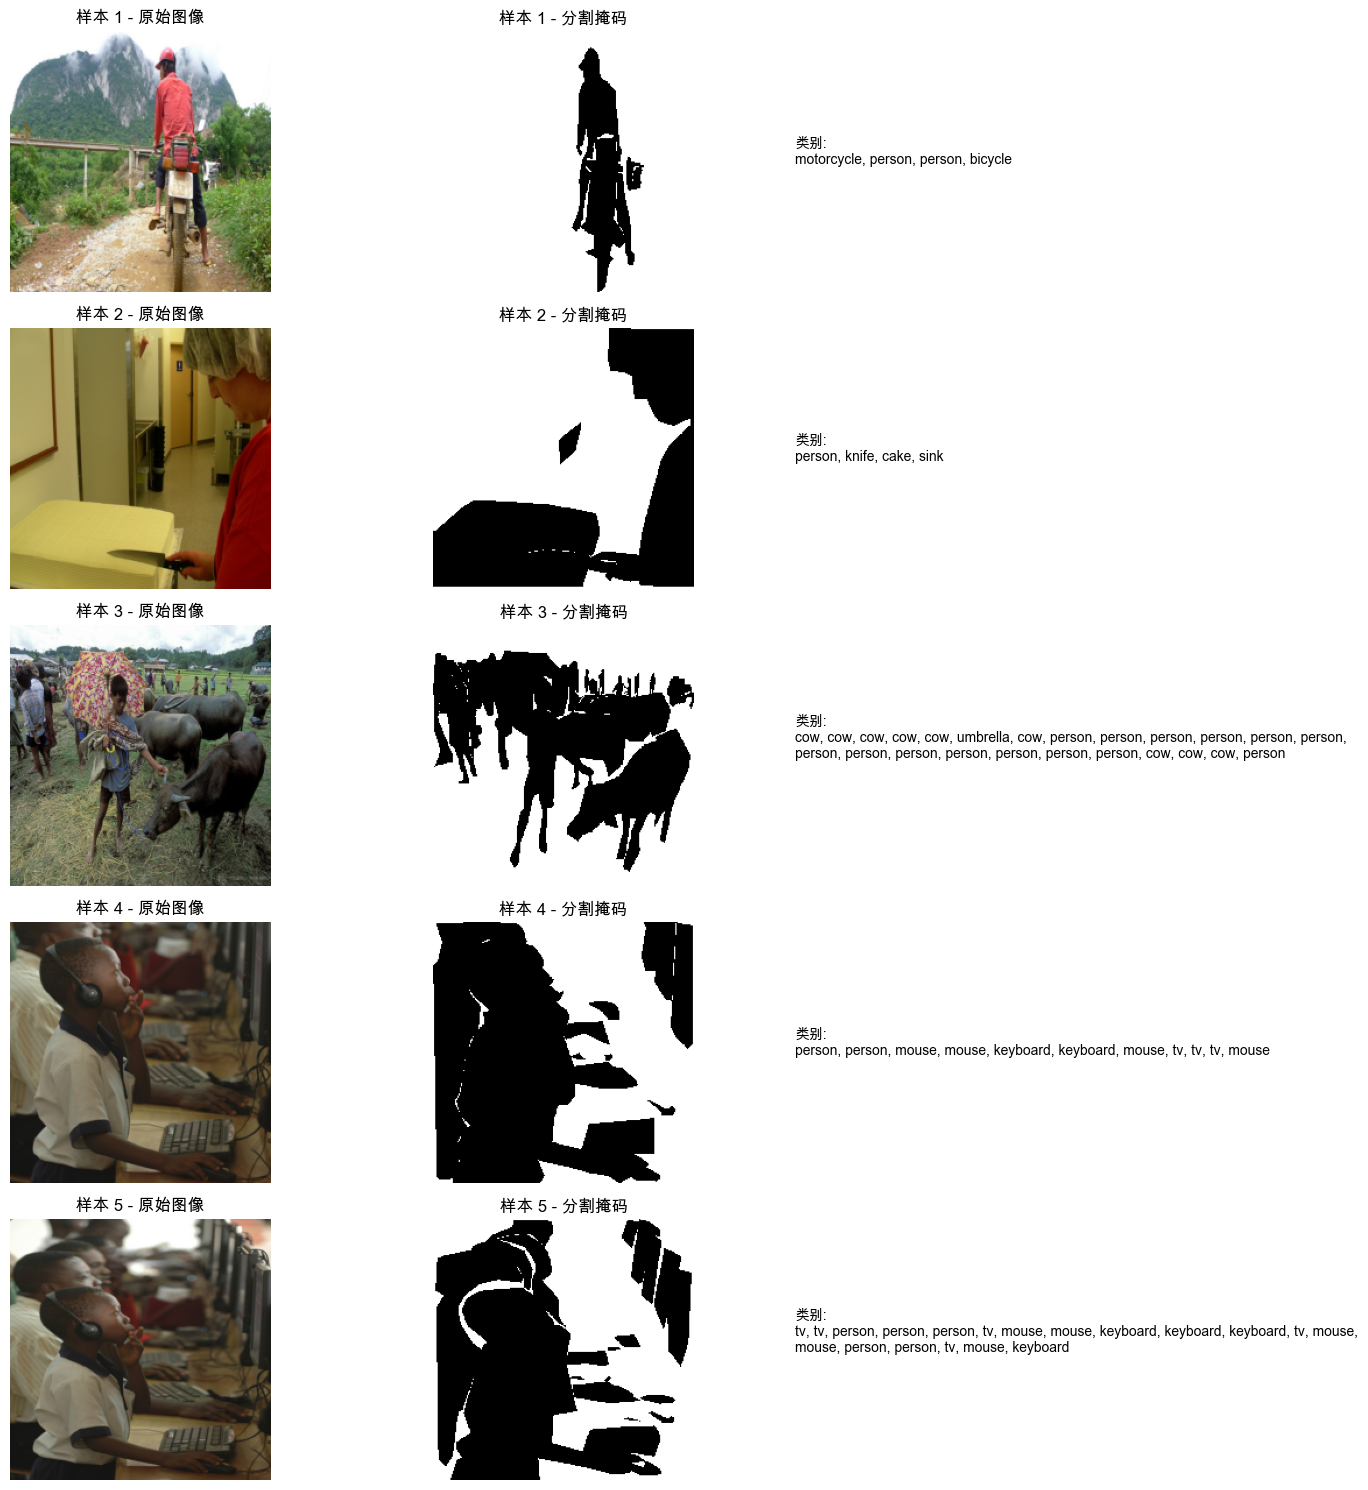

In [5]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = ['Arial Unicode MS']

# 创建可视化函数
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    
    for i in range(num_samples):
        sample = dataset[i]
        
        # 获取数据
        image = sample['image']
        masks = sample['mask']
        labels = sample['label']
        
        # 反归一化图像
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        
        # 转换为numpy格式用于显示
        image = image.permute(1, 2, 0).numpy()
        combined_mask = torch.any(masks > 0.5, dim=0).float().numpy()
        
        # 获取类别名称
        label_names = [dataset.get_cat_name(label.item()) for label in labels]
        
        # 绘制图像
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title(f'样本 {i+1} - 原始图像')
        plt.axis('off')
        
        # 绘制掩码
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(combined_mask, cmap='binary')
        plt.title(f'样本 {i+1} - 分割掩码')
        plt.axis('off')
        
        # 显示类别信息
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.text(0.1, 0.5, f'类别:\n{", ".join(label_names)}', 
                fontsize=10, wrap=True)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化训练集的前5个样本
visualize_samples(train_dataset)

In [6]:
class FPNDecoder(nn.Module):
    def __init__(self, in_channels=256, output_size=(224, 224)):
        super().__init__()
        self.output_size = output_size

        # Upsampling blocks with 3x3 convolutions
        self.up_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(4)
        ])

        # Final 1x1 convolution
        self.final_conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, features):
        # Process each feature map
        upsampled_features = []
        for feat, up_block in zip(features, self.up_blocks):
            # Apply convolution
            x = up_block(feat)
            # Upsample to target size
            x = F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)
            upsampled_features.append(x)

        # Sum all feature maps
        fused_features = sum(upsampled_features)

        # Final mask prediction
        mask = self.final_conv(fused_features)
        return mask

In [7]:
# Initialize decoder with target output size
decoder = FPNDecoder(in_channels=256, output_size=(224, 224))

# Process features of different sizes
features = [torch.randn(1, 256, size, size) for size in [7, 14, 28, 56]]
mask = decoder(features)  # Output size: [1, 1, 224, 224]
mask.shape

torch.Size([1, 1, 224, 224])

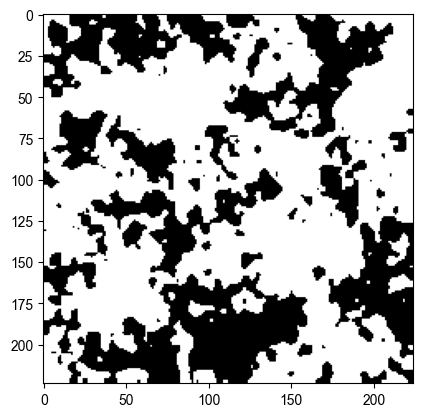

In [8]:
# 因为还没有开始训练，所以掩膜为无规则图像
combined_mask = torch.any(mask > 0.5, dim=0).float().numpy()
plt.imshow(combined_mask.squeeze(), cmap="binary")

In [ ]:
class NaiveConsensusModule(nn.Module):
    def __init__(self, consensus_layers=None):
        super().__init__()
        self.encoder, self.preprocess = local_clip.load("ViT-B/16", device=device)
        self.consensus_layers = consensus_layers if consensus_layers else list(range(8))  # 默认使用所有层
        self.projection = nn.Linear(self.clip.visual.output_dim, self.clip.visual.output_dim)
        self.dispersion = nn.ModuleList([nn.Linear(self.clip.visual.output_dim, self.clip.visual.output_dim) for _ in consensus_layers])

    def forward(self, images):
        """
        images: [batch_size, 3, H, W]
        v: [batch_size, 512]
        F: [batch_size, channels, 716]
        """
        v, F = self.encoder.encode_image(
            self.preprocess(images)
        )

        # 2. 全局共识提取
        cls_tokens = torch.sum(image)
        cls_tokens = image_features[:, 0]  # 提取每个图像的CLS token [batch_size, dim]
        cls_tokens = self.projection(cls_tokens)  # 线性投影调整维度
        cls_tokens = nn.functional.normalize(cls_tokens, dim=-1)  # L2归一化
        consensus = torch.mean(cls_tokens, dim=0, keepdim=True)  # 全局平均 [1, dim]

        # 3. 共识分散到各层
        dispersed = []
        for layer_idx in self.consensus_layers:
            layer_features = image_features[:, layer_idx+1]  # 获取指定层的特征 [batch_size, num_patches, dim]
            layer_features = self.dispersion[layer_idx](layer_features)  # 维度调整
            dispersed_features = layer_features * consensus  # 元素乘法分配共识
            dispersed.append(dispersed_features)

        return dispersed  # 返回所有指定层的增强特征


model = NaiveConsensusModule(consensus_layers=[2, 5])  # 选择第3、6层进行共识分配

# 数据预处理
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 输入图像批次（假设batch_size=4）
batch_images = torch.randn(4, 3, 224, 224)
batch_images = preprocess(batch_images).to(model.clip.device)

# 前向传播
enhanced_features = model(batch_images)
print("增强特征形状:", [f.shape for f in enhanced_features])